In [1]:
from albumentations import *
import os
import cv2
from tqdm import tqdm
import numpy as np
from data_loader import *
import matplotlib.pyplot as plt
from segmentation_models import Unet
%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.
/home/datalab/ex_disk2/hanbing/py36/lib/python3.6/site-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


# 数据增强库测试
- 读取图像
- 可视化图像

In [2]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image[:,:,::-1])
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image[:,:,::-1])
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

In [3]:
aug = Compose([Resize(height=256,width=256,interpolation=cv2.INTER_NEAREST),
               RandomRotate90(p=0.5),
              VerticalFlip(p=0.5),
              HorizontalFlip(p=0.5),
              ChannelShuffle(p=0.5),
              HueSaturationValue(p=0.5),
              RandomBrightnessContrast(0.5),
              Transpose(p=0.5)])

In [10]:
img = cv2.imread('/home/hanbing/datasets/segmentation/facecutimg/srcimg/2500_100_rect0.jpg')
mask = cv2.imread('/home/hanbing/datasets/segmentation/facecutimg/maskimg/2500_100_rect0.png',0)
print('img shape:',img.shape,'mask shape:',mask.shape)

img shape: (110, 148, 3) mask shape: (110, 148)


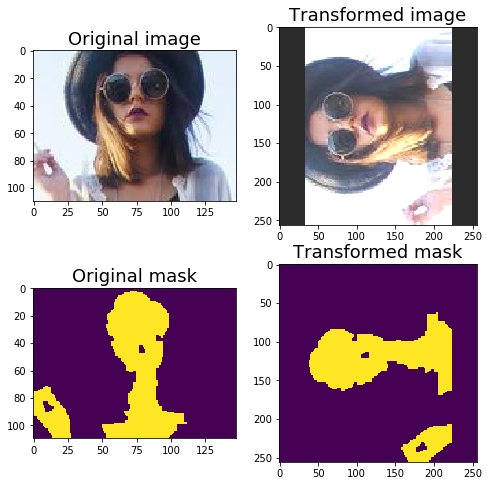

In [11]:
augmented = aug(image=padding(img), mask=padding(mask))

image_padded = augmented['image']
mask_padded = augmented['mask']

visualize(image_padded, mask_padded, original_image=img, original_mask=mask)

# 测试数据生成器是否正常
- 采样函数
- 输出batch数据的某一张

In [ ]:
train,val = GetSampling('/home/hanbing/datasets/segmentation/skin_segmentation/image_head/',
                       '/home/hanbing/datasets/segmentation/skin_segmentation/mask_skin_head/')

In [ ]:
aug = Compose([Resize(height=128,width=128,interpolation=cv2.INTER_AREA),
               RandomRotate90(p=0.5),
              VerticalFlip(p=0.5),
              HorizontalFlip(p=0.5),

              HueSaturationValue(p=0.5),
              RandomBrightnessContrast(0.5),
              Transpose(p=0.5)])
data = DataLoader(train, 2, aug, 16)
data = iter(data)
imgs, masks = next(data)

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0, 0].imshow((imgs[0]*255).astype('uint8'))
ax[0, 1].imshow(np.argmax(masks[0],axis=-1))

# 训练结束后测试模型结果
- 加载模型
- padding，使得可以无形变resize
- 读取图片，预处理
- 显示测试结果

In [6]:
def padding(img):
    shape = img.shape
    h, w = shape[:2]
    width = np.max([h, w])
    padd_h = (width - h) // 2
    padd_w = (width - w) // 2
    if len(shape) == 3:
        padd_tuple = ((padd_h,width-h-padd_h),(padd_w,width-w-padd_w),(0,0))
    else:
        padd_tuple = ((padd_h,width-h-padd_h),(padd_w,width-w-padd_w))
    img = np.pad(img, padd_tuple, 'constant')
    return img 

In [ ]:
model = Unet('resnet34', encoder_weights='imagenet',
                input_shape=(256, 256, 3),
                classes=1,
                activation='sigmoid')
model.load_weights('weights/20190225_res34_cce_dic.h5')

# 测试单张结果

In [ ]:
img = cv2.imread('../../../datasets/segmentation/skin_segmentation/koutu/person_face/00177.jpg')
img = padding(img)
img = cv2.resize(img,(256,256))

In [ ]:
result=model.predict(np.expand_dims(img[:,:,::-1],axis=0) / 255.0)
result[result>=0.5] = 1
result[result<0.5] = 0
re = np.squeeze(result).astype('uint8')

In [ ]:
cv2.addWeighted(img, 1,  cv2.merge([re*128,re*255,re*128]), 0.5, 0, img)

In [ ]:
plt.imshow(img[:,:,::-1])

# 批量测试结果

In [ ]:
path = '/home/hanbing/datasets/segmentation/skin_segmentation/koutu/person_face/'
result = '/home/datalab/ex_disk2/hanbing/data/segmentation/skin_segmentation/result/'
files = [os.path.join(path,i) for i in os.listdir(path) if not i[0]=='.']
print('共有 %d 张测试图片' % len(files))

In [ ]:
for name in tqdm(files):
    img = cv2.imread(name)
    img = padding(img)
    img = cv2.resize(img,(256,256),interpolation=cv2.INTER_AREA)
    
    prediction=model.predict(np.expand_dims(img[:,:,::-1],axis=0) / 255.0)
    # prediction = np.argmax(prediction,axis=-1)[0].astype('uint8')
    prediction[prediction>=0.5] = 1
    prediction[prediction<0.5] = 0da
    prediction = np.squeeze(prediction).astype('uint8')
    img = cv2.addWeighted(img, 1,  cv2.merge([prediction*128,prediction*255,prediction*128]), 0.5, 0)
    cv2.imwrite(os.path.join(result,os.path.basename(name)),img)

# face alignment
接下来是进行人脸关键点检测，测试效果，方便扣掉眼睛和嘴巴对皮肤的干扰

In [ ]:
import os
import cv2
import time
import face_alignment
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, device='cuda:0', face_detector='sfd')
de = face_alignment.detection

In [ ]:
path = '/home/hanbing/work/segmentation/skin/test/image/'
pics = [os.path.join(path,name) for name in os.listdir(path)]

In [ ]:
for pic in pics:
    img = cv2.imread(pic)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    try:
        begin = time.time()
        predss = fa.get_landmarks(img)
        end = time.time()
        print('耗时 %.4f' % (end - begin))
        fig = plt.figure(figsize=plt.figaspect(.5))

        ax = fig.add_subplot(1, 1, 1)
        ax.imshow(img)
        for i in range(len(predss)):
            preds = predss[i]
            ax.plot(preds[0:17,0],preds[0:17,1],marker='o',markersize=2,linestyle='-',color='w',lw=2)
            ax.plot(preds[17:22,0],preds[17:22,1],marker='o',markersize=2,linestyle='-',color='w',lw=2)
            ax.plot(preds[22:27,0],preds[22:27,1],marker='o',markersize=2,linestyle='-',color='w',lw=2)
            ax.plot(preds[27:31,0],preds[27:31,1],marker='o',markersize=2,linestyle='-',color='w',lw=2)
            ax.plot(preds[31:36,0],preds[31:36,1],marker='o',markersize=2,linestyle='-',color='w',lw=2)
            ax.plot(preds[36:42,0],preds[36:42,1],marker='o',markersize=2,linestyle='-',color='w',lw=2)
            ax.plot(preds[42:48,0],preds[42:48,1],marker='o',markersize=2,linestyle='-',color='w',lw=2)
            ax.plot(preds[48:60,0],preds[48:60,1],marker='o',markersize=2,linestyle='-',color='w',lw=2)
            ax.plot(preds[60:68,0],preds[60:68,1],marker='o',markersize=2,linestyle='-',color='w',lw=2) 
        ax.axis('off')
        fig.savefig('result/{}'.format(os.path.basename(pic)))
    except:
        print(pic)